In [1]:
import gym
from stable_baselines3.common.logger import configure
import stable_baselines3
from stable_baselines3 import PPO, DDPG, A2C

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray

import random
import math
from functools import partial
from scipy.stats import gamma

import json
import os
import sys
import time

import fair
from fair.io import read_properties
from fair.interface import fill, initialise

/Users/samart/opt/anaconda3/envs/MLforEE/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
scenario = 'ssp245'
current_year = 2035
end_year = 2105

def ssp(scenario, category='emissions'):
    assert (category=='emissions' or category=='concentrations')
    path = '../data/fair_ssp_scenarios/' + scenario + "_" + category + ".csv"
    ssp = pd.read_csv(path).drop(['Unnamed: 0'], axis=1)
    ssp['Year'] = ssp['Year'].astype(np.int16)
    return(ssp)
ssp_df = ssp(scenario)
size = ssp_df.shape[0]

data_path = '../data/example_github_data/'
volcano_df = pd.read_csv(os.path.join(data_path, 'volcano_forcing_data.csv'), index_col='year').drop(['Unnamed: 0'], axis=1)
climate_df = pd.read_csv(os.path.join(data_path, 'climate_models_data.csv')).drop(['Unnamed: 0'], axis=1)

# cost model for CO2 and Sulfur Emissions
beta = 1.03 # estimated GDP growth rate over the year
GtC_reduce_cost = 6e11
cost_per_MT = 1000 * 1e6 # cost per ton * 10^6 tons / Mt
airplane_construction_cost = 1e8 # construction of additional airplane
cost_per_year_deployed = 12 * 8e5 # annual lease rate = 12 * monthly
payload_per_year_tons = 20 * 5  * 330 # tons/run * runs / day * operating days/year
annual_delivery_capacity = payload_per_year_tons / 1e6 # how much sulfur a single plane can emit in a year

Y = pd.Series(data=np.zeros(size), index=ssp_df['Year']) #global GDP
Y_cost = pd.Series(data=np.zeros(size), index=ssp_df['Year']) #cost of climate change

Y.loc[:current_year-1] = 9e13 #USD/a
Y_cost.loc[:current_year-1] = 100*1e9 #USD/a

Y[current_year] = 9.2e13 #USD/a
Y_cost[current_year] = 100*1e9 #USD/a

# basic model
species, properties = read_properties()
averages = climate_df.drop_duplicates(subset=['model'], keep='first').mean(numeric_only=True)

In [3]:
def setup_model(end_year=end_year, scenario='ssp245', timesteps_per_year=1):
    
    # consider fiddling with sulfur properties since forcing seems weak and f.forcing does not include sulfur
    
    f = fair.FAIR(ghg_method= 'meinshausen2020', ch4_method='thornhill2021')
    f.define_time(1750, end_year, 1/timesteps_per_year) #timepoints, timebounds
    f.define_scenarios([scenario])
    f.define_configs(['default', 'intervention'])
    f.define_species(species, properties)
    f.timesteps_per_year = timesteps_per_year
    f.allocate()

    # fill species configs using default values
    f.fill_species_configs()
    fill(f.species_configs['unperturbed_lifetime'], 10.8537568, specie='CH4')
    fill(f.species_configs['baseline_emissions'], 19.01978312, specie='CH4')
    fill(f.species_configs['baseline_emissions'], 0.08602230754, specie='N2O')

    # Use climate_df for climate configs. take the average of the first runs of all models to obtain climate params
    fill(f.climate_configs['ocean_heat_capacity'], averages.loc['C1':'C3'].values)
    fill(f.climate_configs['ocean_heat_transfer'], averages.loc['kappa1':'kappa3'].values)
    fill(f.climate_configs['deep_ocean_efficacy'], averages['epsilon'])
    fill(f.climate_configs['gamma_autocorrelation'], averages['gamma'])
    fill(f.climate_configs['sigma_eta'], averages['sigma_eta'])
    fill(f.climate_configs['sigma_xi'], averages['sigma_xi'])
    fill(f.climate_configs['stochastic_run'], True)
    fill(f.climate_configs['use_seed'], True)
    fill(f.climate_configs['seed'], 1355763)

    f.fill_from_rcmip()

    volcanic_forcing = np.zeros(f.timebounds.size)
    volcanic_forcing[:timesteps_per_year*270] = volcano_df.iloc[::int(12/timesteps_per_year)].squeeze().values
    fill(f.forcing, volcanic_forcing[:, None, None], specie='Volcanic')

    initialise(f.concentration, f.species_configs['baseline_concentration'])
    initialise(f.forcing, 0)
    initialise(f.temperature, 0)
    initialise(f.cumulative_emissions, 0)
    initialise(f.airborne_emissions, 0)
    
    return(f)
ref_model = setup_model(end_year, scenario, 1)
def model_reset(end_year=end_year, timesteps_per_year=1): # faster than setup_model() because that function is too slow in practice
    g = fair.FAIR(ghg_method= 'meinshausen2020', ch4_method='thornhill2021')
    g.define_time(1750, end_year, 1) #timepoints, timebounds
    g.define_scenarios([scenario])
    g.define_configs(['default', 'intervention'])
    g.define_species(species, properties)
    g.allocate()
    
    g.timesteps_per_year = timesteps_per_year
    g.species_configs = ref_model.species_configs.copy(deep=True)
    g.climate_configs = ref_model.climate_configs.copy(deep=True)
    g.emissions = ref_model.emissions.copy(deep=True)
    g.concentration = ref_model.concentration.copy(deep=True)
    g.forcing = ref_model.forcing.copy(deep=True)
    g.forcing_sum = ref_model.forcing_sum.copy(deep=True)
    g.temperature = ref_model.temperature.copy(deep=True)
    g.cumulative_emissions = ref_model.cumulative_emissions.copy(deep=True)
    g.airborne_emissions = ref_model.airborne_emissions.copy(deep=True)
    g.airborne_fraction = ref_model.airborne_fraction.copy(deep=True)
    g.ocean_heat_content_change = ref_model.ocean_heat_content_change.copy(deep=True)
    g.stochastic_forcing = ref_model.stochastic_forcing.copy(deep=True)
    g.toa_imbalance = ref_model.toa_imbalance.copy(deep=True)
    
    return(g)

In [4]:
def carbon_cost_GDP_reward(old_state, state, year, GDP, GDP_cost, cur_fease):
    cur_temp = state[0]
    beta = 100 if cur_fease < 0 else 1
    reward = beta * cur_fease
    alpha = 1000 if cur_temp > 2 else 200
    reward += alpha * (2-cur_temp)  
    reward += GDP/1e12
    reward -= GDP_cost/1e11
    
    if(reward>10000):
        print("From inside reward function, reward: ", reward)
        print('fease', cur_fease, "temp: ", alpha * (2-cur_temp), 'GDP: ', GDP/1e12)
        
    return reward

In [49]:
args = {
    'name': 'Fred',
    'directory': 'Experiment_3/',
    'max_carbon': 1,
    'max_sulfur': 60,
    'reward_mode': 'carbon_cost_GDP_reward',
    'scenario': 'ssp245',
    'start_year' : 2023,
    'end_year': 2105,
    'algorithm': 'ppo',
    'learning_rate': 0.024,
    'gamma': 0.85,
    'device': 'cpu',
    'iterations': 100,
    'n_steps': 4,
    'verbose': 2,
    'log_freq': 100
}

In [50]:
class Simulator(gym.Env):
    
    def __init__(self, args, aero_start_year):
        
        super(Simulator, self).__init__()
        
        # action space for the environment, normalized for better RL training
        # the amount to increase or decrease emissions by
        self.action_space = gym.spaces.Box(
            low = np.array([-1, -1]).astype(np.float32),
            high = np.array([1, 1]).astype(np.float32),
        ) 
        self.model = model_reset()
        
        # state space, year [temp, co2_emit, sulfur_emit, co2_conc, forcing]
        """self.observation_space = gym.spaces.Box(
            low=np.array([-4, -200, -100, 0, -20.0]).astype(np.float32),
            high=np.array([5, 200, 1000, 5000, 20.0]).astype(np.float32),
        )"""
        
        self.obs_scalars = np.array([6, 200, 200+args['max_sulfur'], 2000, 20], dtype=np.float32)
        
        self.observation_space = gym.spaces.Box(
            low=np.array([-1, -1, -1, -1, -1]).astype(np.float32),
            high=np.array([1,1,1,1,1]).astype(np.float32),
        )
        
        self.reward_func = eval(args['reward_mode']) # specify the reward function to use
        self.state = None
        self.ssp_370 = ssp('ssp370') #for feasibility testing later
        self.max_carbon = args['max_carbon']
        self.max_aerosol = args['max_sulfur']
        
        # setup time bounding
        self.start_year = args['start_year']
        self.end_year = args['end_year']
        self.time_increment = self.model.timesteps_per_year # gonna be 1
        
        self.aerosol_start = aero_start_year
        
        # used for aerosol cost
        self.airplanes_manufactured = 0
    
        
    def reset(self):
        
        ## RESET ECONOMIC VARIABLES
        
        Y = pd.Series(data=np.zeros(size), index=ssp_df['Year']) #global GDP
        Y_cost = pd.Series(data=np.zeros(size), index=ssp_df['Year']) #cost of climate change
        S = pd.Series(data=np.zeros(size), index=ssp_df['Year']) #renewable knowledge stock

        S.loc[:current_year-1] = 5e11 #GJ
        Y.loc[:current_year-1] = 9e13 #USD/a
        Y_cost.loc[:current_year-1] = 100*1e9 #USD/a

        S[current_year] = 5e11 #GJ
        Y[current_year] = 9.2e13 #USD/a
        Y_cost[current_year] = 100*1e9 #USD/a
        
        ##             ##
        
        
        ## reset- faster than calling setup_model() again
        self.model = model_reset()
        self.t = self.start_year - 1
        
        self.update_state(ref_model.emissions)
        
        return(self.state[self.model.configs[1]] / self.obs_scalars)                           
    
    
    def update_state(self, emissions):
        
        self.forward_func(emissions)   
        # state is [year, temp, co2_emit, sulfur_emit, co2_conc, forcing]   
        # state refers to at the conclusion of year X, all variables. At end, we are at beginning of year X+1
        self.state = {
            'Year' : self.t,
            self.model.configs[0] : np.array([
                self.model.temperature.loc[self.t, self.model.scenarios[0], self.model.configs[0], 0].item(),
                self.model.emissions.loc[self.t - self.time_increment/2, self.model.scenarios[0], self.model.configs[0], :][:2].sum().item(),
                self.model.emissions.loc[self.t - self.time_increment/2, self.model.scenarios[0], self.model.configs[0], 'Sulfur'].item(),
                self.model.concentration.loc[self.t, self.model.scenarios[0], self.model.configs[0], 'CO2'].item(),
                self.model.forcing_sum.loc[self.t, self.model.scenarios[0], self.model.configs[0]].item()                
            ], dtype=np.float32),
            self.model.configs[1] : np.array([ 
                self.model.temperature.loc[self.t, self.model.scenarios[0], self.model.configs[1], 0].item(),
                self.model.emissions.loc[self.t - self.time_increment/2, self.model.scenarios[0], self.model.configs[1], :][:2].sum().item(),
                self.model.emissions.loc[self.t - self.time_increment/2, self.model.scenarios[0], self.model.configs[1], 'Sulfur'].item(),
                self.model.concentration.loc[self.t, self.model.scenarios[0], self.model.configs[1], 'CO2'].item(),
                self.model.forcing_sum.loc[self.t, self.model.scenarios[0], self.model.configs[1]].item()
            ], dtype=np.float32)
        }
                               
        self.t += self.time_increment
    
    def access_state(self):
        return(self.state)
    
    def forward_func(self, emissions):

        self.model = model_reset()
        self.model.emissions = emissions.copy(deep=True)
        try:
            self.model.run(progress=False)
        except ValueError:
            print("Valueerror in forward func")
            print("emissions shape: ", self.model.emissions.shape)
            print("expected shape: ", model_reset().emissions.shape)
    
    def aerosol_cost(self, emit):
        
        # 3 factors: operating cost, construction cost, sulfur cost
        num_airplanes = emit / annual_delivery_capacity # how many airplaces deployed
        operational_cost = num_airplanes * cost_per_year_deployed
        
        num_new_airplaces = num_airplanes - self.airplanes_manufactured # number of new planes needed to service additional emissions
        construction_cost = max(num_new_airplaces, 0) * airplane_construction_cost # cost of constructing new plances
        
        sulfur_cost = emit * cost_per_MT
        
        self.airplanes_manufactured = max(int(num_airplanes), int(self.airplanes_manufactured))
        
        return(sulfur_cost + construction_cost + operational_cost)
        
    
    def render(self, mode="human"):
        if(self.state):
            print(f"Current Year: {self.state['Year']}")
            print("Without intervention:")
            config = self.model.configs[0]
            # print the state [year, temp, co2_emit, sulfur_emit, co2_conc, forcing]
            print(f'    Temperature anomaly: {self.state[config][0]}ºC')
            print(f'    CO2 emissions: {self.state[config][1]} GtC')
            print(f'    Sulfur emissions: {self.state[config][2]} MtS')
            print(f'    CO2 concentration: {self.state[config][3]} ppm')
            print(f'    Radiative forcing: {self.state[config][4]} W/m2')
            
            print("\nWith intervention:")
            config = self.model.configs[1]
            # print the state [year, temp, co2_emit, sulfur_emit, co2_conc, forcing]
            print(f'    Temperature anomaly: {self.state[config][0]}ºC')
            print(f'    CO2 emissions: {self.state[config][1]} GtC')
            print(f'    Sulfur emissions: {self.state[config][2]} MtS')
            print(f'    CO2 concentration: {self.state[config][3]} ppm')
            print(f'    Radiative forcing: {self.state[config][4]} W/m2')
        else:
            print("No state initialized; call reset. ")
    
    
    def step(self, action):
        
        #should not call step without calling reset()
        if(not self.state): #has not been initialized
            self.reset()
    
        config = self.model.configs[1] #intervention
        old_state = self.state[config] #save for reward function
        year = self.t
        done = False
        
        geoengineering = year >= self.aerosol_start # boolean indicator whether allowed to emit sulfur or not
        
        
        # change emissions by action[0] from the previous year
        # emit action amount additional sulfur within same year
        new_emissions = self.model.emissions
        emit_C = self.max_carbon * action[0] + new_emissions.loc[self.t-0.5, self.model.scenarios[0], config, 'CO2 FFI'].item()
        new_emissions.loc[self.t+0.5, self.model.scenarios[0], config, 'CO2 FFI'] = max(emit_C, 0)
        if geoengineering:
            emit_S = new_emissions.loc[self.t+0.5, self.model.scenarios[0], config, 'Sulfur'] + self.max_aerosol*abs(action[1])
            new_emissions.loc[self.t+0.5, self.model.scenarios[0], config, 'Sulfur'] = emit_S

        
        # run model simulation with new values
        #state is [year, temp, emit_c, emit_s, conc_c, forcing]
        self.update_state(new_emissions) #CAUTION! self.t has now changed
        
        #Implementation of S, Y and Y_cost
        Y[year] = beta * Y[year-1] # assume constant GDP growth of beta percent
        
        emission_cost = GtC_reduce_cost * (old_state[1] - self.state[config][1])
        Y_cost[year] = (10/5 * self.state[config][0] - 2)/100 * Y[year] + self.aerosol_cost(action[1]) + emission_cost
        
        #gamma = 1 / ( 1+(S[year-1]/sigma)**rho )
        #S[year] = S[year-1] + ( (1-gamma)*Y[year-1]/epsilon - S[year-1]/tau_S ) # not used in this implementation
        
        # fail if temperature error
        if math.isnan(self.state[config][0]):
            done = True
        
        
        cur_fease = emit_C - self.ssp_370[self.ssp_370['Year']==year]['CO2-fossil (GtC/yr)'].squeeze() # positive if emitted more than default, otherwise negative
        Y[year] = Y[year] - Y_cost[year] # update GDP to reflect cost of climate change
        
        #compute the reward
        reward = self.reward_func(old_state, self.state[config], year, Y[year], Y_cost[year], cur_fease)
        

        # end the trial once 2100 is reached or if temp anomaly above 4 degrees
        if year == self.end_year-1 or self.state[config][0] > 4: # only runs to 2100
            done = True
        
        observation = self.state[self.model.configs[1]] / self.obs_scalars
        
        return observation, reward, done, {}
        

In [51]:
env = Simulator(args, 2105)
env.reset()
for i in range(40):
    env.step(env.action_space.sample())
    if(env.state['default'][2] != env.state['intervention'][2]):
        print("BLASPHEMY in year ", 2023+i)

In [54]:
args['name'] = 'Tom'
args

{'name': 'Tom',
 'directory': 'Experiment_3/',
 'max_carbon': 1,
 'max_sulfur': 60,
 'reward_mode': 'carbon_cost_GDP_reward',
 'scenario': 'ssp245',
 'start_year': 2023,
 'end_year': 2105,
 'algorithm': 'ppo',
 'learning_rate': 0.024,
 'gamma': 0.85,
 'device': 'cpu',
 'iterations': 100,
 'n_steps': 4,
 'verbose': 2,
 'log_freq': 100}

In [55]:
def setup_dirs(args):
    save_path = os.path.join("outputs", args['directory'])
    dirs = ['plots', 'logs', 'saved_models']
    for direc in dirs:
        path = os.path.join(save_path, direc)
        if not os.path.exists(path):
            os.makedirs(path)
    
    # save args configs
    with open(os.path.join(save_path, args['name']+'_config.txt'), 'w') as file:
        json.dump(args, file, indent=2)
    
    return save_path

def create_model(args, start_year, climate_model = model_reset()):
    save_path = setup_dirs(args)
    
    env = Simulator(args, start_year)
    
    env.reset()
    
    model_builder = eval(args['algorithm'].upper()) # import from stable baselines
    model = model_builder(
        policy="MlpPolicy",
        env=env,
        learning_rate = args['learning_rate'],
        n_steps = args['n_steps'],
        gamma= args['gamma'],
        verbose=args['verbose'],
        tensorboard_log=os.path.join(save_path, 'logs', args['name']),
    )

    model.set_logger(configure(
        os.path.join(save_path, 'logs', args['name']),
        ["csv", "tensorboard"]
    ))
    
    return model, save_path


VARS = ['Year', 'Temperature Anomaly (°C)', 'CO2 Emitted (GtC/yr)', 'Sulfur Emitted (MtS/yr)', 'CO2 Concentration (ppm)', 'ERF (W/m2)', 'Reward']

def evaluate_model(model, args, start_year, test_iters=100, climate_model= model_reset()):
    save_path = os.path.join("outputs", args['directory'])
    model_path = os.path.join(save_path, 'saved_models', args['name'])
    model.save(model_path) # for easier reference
    print("Model at ", model_path)
    
    env = Simulator(args, start_year)
    
        
    obs = env.reset()
    def_vals = []
    intervention_vals = []
    for i in range(test_iters):
        action, _ = model.predict(obs, deterministic=False)
        obs, reward, done, _ = env.step(action)
        state = env.access_state()
    
        
        # get values for default and for intervention for comparison
        def_vals.append(np.concatenate((np.array([state['Year']]), state[env.model.configs[0]], np.array([reward]))))
        intervention_vals.append(np.concatenate((np.array([state['Year']]), state[env.model.configs[1]], np.array([reward]))))
        
        if(i%25==0):
            print("Iteration number: ", i)
        
        if done:
            print("\n\nSimulation concluded at iteration: ", i)
            print(env.t)
            env.render()
            env.reset()
            break;
    
    if(env.close is not None):
        env.close()
        
    return pd.DataFrame(data=intervention_vals, columns=VARS), pd.DataFrame(data=def_vals, columns=VARS)
 


# Output useful plots
def make_plots(start_year, aero_vals, def_vals, save_path, style = 'seaborn-darkgrid'):
    plt.style.use(style)
    print(type(eval("aero_vals")))
    data_path = os.path.join(save_path, 'logs', args['name'], str(start_year))
    if not os.path.exists(data_path):
        os.makedirs(data_path)
    aero_vals.to_csv(os.path.join(data_path, "intervention.csv"))
    def_vals.to_csv(os.path.join(data_path, "default.csv"))
    
    
    plots_path = os.path.join(save_path, 'plots', args['name'], str(start_year))
    if not os.path.exists(plots_path):
        os.makedirs(plots_path)
    
    for col in aero_vals.columns[1:-1]:
        plt.plot(aero_vals['Year'], aero_vals[col], label='geoengineering')
        plt.plot(def_vals['Year'], def_vals[col], label='default')
        plt.title(str(start_year) + " start: " + col[:col.index("(")-1])
        plt.ylabel(col)
        plt.xlabel('Year')
        plt.legend(loc='upper left')
        try:
            plt.savefig(os.path.join(plots_path, col[:col.index("(")-1]))
        except ValueError:
            plt.savefig(os.path.join(plots_path, col))
        plt.clf()
    
    # Plot Reward a little differently
    col = aero_vals.columns[-1]
    plt.plot(aero_vals['Year'], aero_vals[col])
    plt.plot(def_vals['Year'], def_vals[col])
    plt.ylabel(col)
    plt.xlabel('Year')
    plt.savefig(os.path.join(plots_path, col))
    

## Start in 2025

In [ ]:
# Output useful plots
def make_plots(start_year, aero_vals, def_vals, save_path:
    
    plots_path = os.path.join(save_path, 'plots', args['name'], str(start_year))
    if not os.path.exists(plots_path):
        os.makedirs(plots_path)
    
    for col in aero_vals.columns[1:-1]:
        plt.plot(aero_vals['Year'], aero_vals[col], label='geoengineering')
        plt.plot(def_vals['Year'], def_vals[col], label='default')
        plt.title(str(start_year) + " start: " + col[:col.index("(")-1])
        plt.ylabel(col)
        plt.xlabel('Year')
        plt.legend(loc='upper left')
        try:
            plt.savefig(os.path.join(plots_path, col[:col.index("(")-1]))
        except ValueError:
            plt.savefig(os.path.join(plots_path, col))
        plt.clf()
    

In [56]:
model, save_path = create_model(args, 2025)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/samart/opt/anaconda3/envs/MLforEE/lib/python3.10/site-packages/stable_baselines3/ppo/ppo.py:151: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 4`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 4
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=4 and n_envs=1)
  warnings.warn(


In [57]:
args

{'name': 'Tom',
 'directory': 'Experiment_3/',
 'max_carbon': 1,
 'max_sulfur': 60,
 'reward_mode': 'carbon_cost_GDP_reward',
 'scenario': 'ssp245',
 'start_year': 2023,
 'end_year': 2105,
 'algorithm': 'ppo',
 'learning_rate': 0.024,
 'gamma': 0.85,
 'device': 'cpu',
 'iterations': 100,
 'n_steps': 4,
 'verbose': 2,
 'log_freq': 100}

In [58]:
# use model from Experiment 2, saved here
load_path = 'outputs/Experiment_3/saved_models/John'
model = PPO.load(load_path, model.env)
model.env

In [59]:
aerosol, default = evaluate_model(model, args, 2025)

Model at  outputs/Experiment_3/saved_models/Tom
Iteration number:  0
Iteration number:  25
Iteration number:  50
Iteration number:  75


Simulation concluded at iteration:  81
2105
Current Year: 2104
Without intervention:
    Temperature anomaly: 3.4366579055786133ºC
    CO2 emissions: 9.681204795837402 GtC
    Sulfur emissions: 30.246562957763672 MtS
    CO2 concentration: 606.2730712890625 ppm
    Radiative forcing: 5.42453145980835 W/m2

With intervention:
    Temperature anomaly: 1.9873497486114502ºC
    CO2 emissions: -4.512072563171387 GtC
    Sulfur emissions: 90.24656677246094 MtS
    CO2 concentration: 423.979248046875 ppm
    Radiative forcing: 2.834717273712158 W/m2


<class 'pandas.core.frame.DataFrame'>


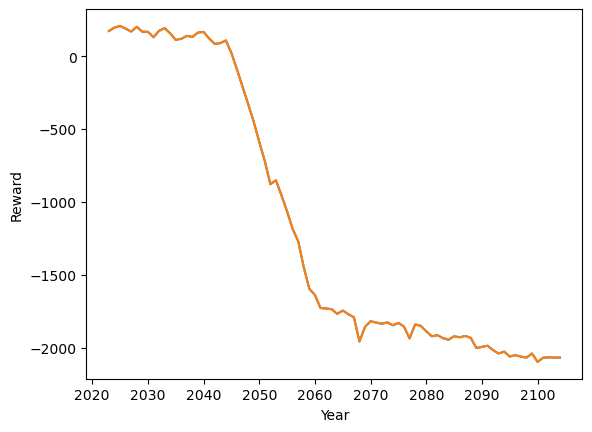

In [60]:
make_plots(2025, aerosol, default, save_path)

#### Starts in 2035

In [61]:
aerosol2, default2 = evaluate_model(model, args, 2035)

Model at  outputs/Experiment_3/saved_models/Tom
Iteration number:  0
Iteration number:  25
Iteration number:  50
Iteration number:  75


Simulation concluded at iteration:  81
2105
Current Year: 2104
Without intervention:
    Temperature anomaly: 3.4366579055786133ºC
    CO2 emissions: 9.681204795837402 GtC
    Sulfur emissions: 30.246562957763672 MtS
    CO2 concentration: 606.2730712890625 ppm
    Radiative forcing: 5.42453145980835 W/m2

With intervention:
    Temperature anomaly: 1.9937900304794312ºC
    CO2 emissions: -4.512072563171387 GtC
    Sulfur emissions: 90.24656677246094 MtS
    CO2 concentration: 424.22515869140625 ppm
    Radiative forcing: 2.8374099731445312 W/m2


<class 'pandas.core.frame.DataFrame'>


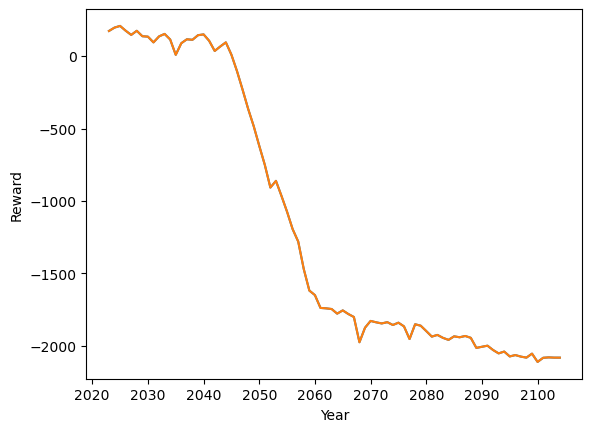

In [62]:
make_plots(2035, aerosol2, default2, save_path)

#### Starts in 2050

In [63]:
aerosol3, default3 = evaluate_model(model, args, 2050)

Model at  outputs/Experiment_3/saved_models/Tom
Iteration number:  0
Iteration number:  25
Iteration number:  50
Iteration number:  75


Simulation concluded at iteration:  81
2105
Current Year: 2104
Without intervention:
    Temperature anomaly: 3.4366579055786133ºC
    CO2 emissions: 9.681204795837402 GtC
    Sulfur emissions: 30.246562957763672 MtS
    CO2 concentration: 606.2730712890625 ppm
    Radiative forcing: 5.42453145980835 W/m2

With intervention:
    Temperature anomaly: 2.0375988483428955ºC
    CO2 emissions: -4.512072563171387 GtC
    Sulfur emissions: 90.24656677246094 MtS
    CO2 concentration: 429.005615234375 ppm
    Radiative forcing: 2.897770881652832 W/m2


<class 'pandas.core.frame.DataFrame'>


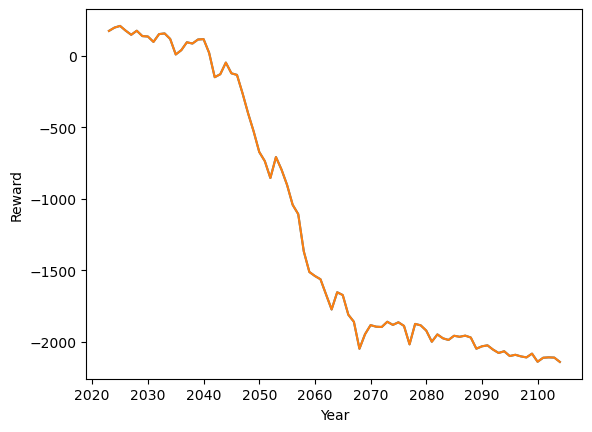

In [64]:
make_plots(2050, aerosol3, default3, save_path)

#### Starts in 2065

In [68]:
aerosol4, default4 = evaluate_model(model, args, 2065)

Model at  outputs/Experiment_3/saved_models/Tom
Iteration number:  0
Iteration number:  25
Iteration number:  50
Iteration number:  75


Simulation concluded at iteration:  81
2105
Current Year: 2104
Without intervention:
    Temperature anomaly: 3.4366579055786133ºC
    CO2 emissions: 9.681204795837402 GtC
    Sulfur emissions: 30.246562957763672 MtS
    CO2 concentration: 606.2730712890625 ppm
    Radiative forcing: 5.42453145980835 W/m2

With intervention:
    Temperature anomaly: 2.0163650512695312ºC
    CO2 emissions: -4.512072563171387 GtC
    Sulfur emissions: 90.24656677246094 MtS
    CO2 concentration: 425.05224609375 ppm
    Radiative forcing: 2.845707416534424 W/m2


<class 'pandas.core.frame.DataFrame'>


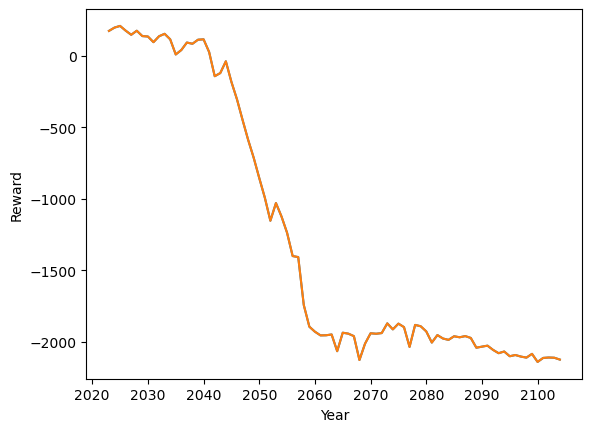

In [69]:

make_plots(2065, aerosol4, default4, save_path)

In [93]:
plt.style.use('seaborn-darkgrid')
plt.rcParams["figure.figsize"] = (16,9)
aero_vals, def_vals, start_year = aerosol4, default4, 2065
plots_path = os.path.join(save_path, 'plots', args['name'], str(start_year))
if not os.path.exists(plots_path):
    os.makedirs(plots_path)

for col in aero_vals.columns[1:-1]:
    plt.plot(aero_vals['Year'], aero_vals[col], label='geoengineering', color='green')
    plt.plot(def_vals['Year'], def_vals[col], label='default', color='purple')
    plt.title(str(start_year) + " start: " + col[:col.index("(")-1])
    plt.ylabel(col)
    plt.xlabel('Year')
    plt.legend(loc='upper left')
    plt.savefig(os.path.join(plots_path, col[:col.index("(")-1]))

    plt.clf()

<Figure size 1600x900 with 0 Axes>

In [97]:
plt.style.use('classic')

In [76]:
import matplotlib
matplotlib.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

# Analyze data

In [1]:
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [6]:
path = 'outputs/Experiment_3/logs/Tom/'
aero1, def1 = pd.read_csv(os.path.join(path, str(2025), 'intervention.csv')).drop(['Unnamed: 0'], axis=1), pd.read_csv(os.path.join(path, str(2025), 'default.csv')).drop(['Unnamed: 0'], axis=1)
aero2, def2 = pd.read_csv(os.path.join(path, str(2035), 'intervention.csv')).drop(['Unnamed: 0'], axis=1), pd.read_csv(os.path.join(path, str(2035), 'default.csv')).drop(['Unnamed: 0'], axis=1)
aero3, def3 = pd.read_csv(os.path.join(path, str(2050), 'intervention.csv')).drop(['Unnamed: 0'], axis=1), pd.read_csv(os.path.join(path, str(2050), 'default.csv')).drop(['Unnamed: 0'], axis=1)
aero4, def4 = pd.read_csv(os.path.join(path, str(2065), 'intervention.csv')).drop(['Unnamed: 0'], axis=1), pd.read_csv(os.path.join(path, str(2065), 'default.csv')).drop(['Unnamed: 0'], axis=1)



In [21]:
cols

Index(['Year', 'Temperature Anomaly (°C)', 'CO2 Emitted (GtC/yr)',
       'Sulfur Emitted (MtS/yr)', 'CO2 Concentration (ppm)', 'ERF (W/m2)',
       'Reward'],
      dtype='object')

In [43]:
ind = aero1[aero1['Year']==2050.0].index[0]
ind

27

In [48]:
col = 'CO2 Emitted (GtC/yr)'
data = [str(aero1[col][ind]), str(aero2[col][ind]), str(aero3[col][ind]), str(aero4[col][ind])]


b = " & ".join(data)
print(b)

11.696695327758787 & 11.696695327758787 & 13.696695327758787 & 11.696695327758787
